[ 0.48422691  0.82917612  2.52523815 -0.24964589 -0.88411261  1.35221757
  1.16210976 -0.26839409  0.24883824  3.59544757  1.20977716]


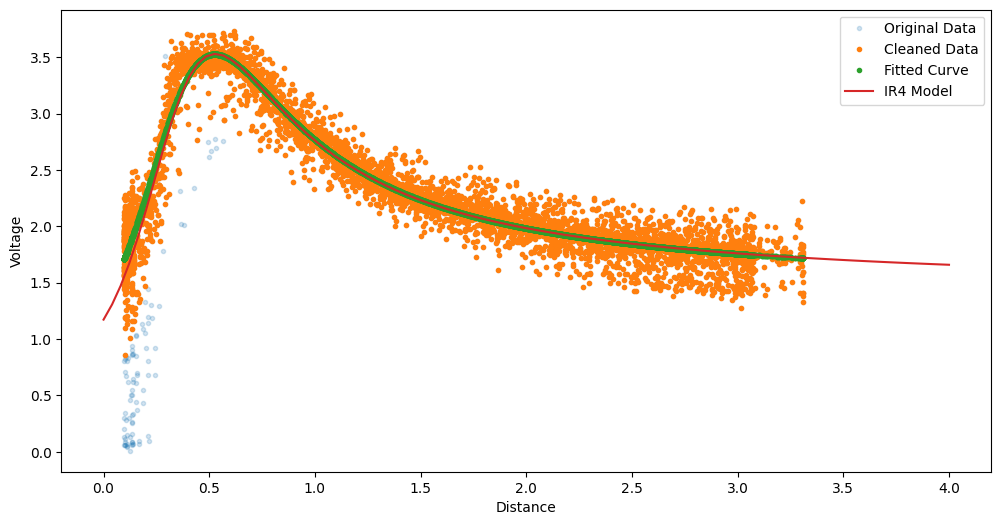

In [1]:
import scipy as sp
import Model.IR_model as mm
from numpy import loadtxt, gradient
matplotlib.style.use('default')
from matplotlib.pyplot import subplots, show
import matplotlib.pyplot as plt
import numpy as np

# Load data
filename = 'partA/training1.csv'
data = loadtxt(filename, delimiter=',', skiprows=1)

# Split into columns
index, time, distance, velocity_command, raw_ir1, raw_ir2, raw_ir3, raw_ir4, \
    sonar1, sonar2 = data.T

# Remove outliers for IR4 sensor
ir4_x, ir4_v, ir4_fit, ir4_params = mm.remove_outlier(mm.ir4_model, distance, raw_ir4, 3)
print(ir4_params)

# Extract parameters from the IR4 sensor model
a1_ir4 = ir4_params[0]
b1_ir4 = ir4_params[1]
a2_ir4 = ir4_params[2]
b2_ir4 = ir4_params[3]
c1_ir4 = ir4_params[4]
c2_ir4 = ir4_params[5]
d1_ir4 = ir4_params[6]
d2_ir4 = ir4_params[7]
e1_ir4 = ir4_params[8]
e2_ir4 = ir4_params[9]
f_ir4 = ir4_params[10]

# Define a function h_ir4 based on the extracted parameters
h_ir4 = lambda x: (a1_ir4*(x+d1_ir4)**2 + b1_ir4*(x+e1_ir4) + c1_ir4) / (a2_ir4*(x+d2_ir4)**2 + b2_ir4*(x+e2_ir4) + c2_ir4) + f_ir4

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Plot the original data points for IR4 with a label
plt.plot(distance, raw_ir4, '.', alpha=0.2, label='Original Data')

# Plot the cleaned IR4 data points with a label
plt.plot(ir4_x, ir4_v, '.', label='Cleaned Data')

# Plot the fitted curve for IR4 with a label
plt.plot(ir4_x, ir4_fit, '.', label='Fitted Curve')

# Generate x-values for the IR4 model curve
x_values = np.linspace(0, 4, 100)

# Plot the IR4 model curve using the extracted parameters with a label
plt.plot(x_values, mm.ir4_model(x_values, *ir4_params), label='IR4 Model')

# Add labels for the x-axis and y-axis
plt.xlabel("Distance")
plt.ylabel("Voltage")

# Display a legend
plt.legend()

plt.show()


In [2]:
import numpy as np

# Function to calculate the derivative of a given function 'func' at point 'x'
def diff(func, x):
    dx = 0.001
    return (func(x + dx) - func(x)) / dx

# Function to invert 'sensor_model' to find 'curguess' such that 'sensor_model(curguess)' is close to 'z'
def H_invert(sensor_model, z, scope=(0, 10)):
    half = (scope[1] - scope[0]) / 2
    curguess = scope[1] / 2
    lim = 0
    maxLim = 1000
    
    while (np.abs(sensor_model(curguess) - z) > 0.0001 and lim < maxLim):
        lim += 1
        if sensor_model(curguess) > z:
            if diff(sensor_model, curguess) > 0:  # If positive slope
                curguess -= half / 2
            else:
                curguess += half / 2
        else:
            if diff(sensor_model, curguess) > 0:  # If positive slope
                curguess += half / 2
            else:
                curguess -= half / 2
        half /= 2

    if np.abs(sensor_model(curguess) - z) > 0.0001:
        return None
    else:
        return curguess

# Function to find two guesses using 'invertH' within specified range 'scope'
def amb_H_invert(sensor_model, z, mid, scope=(0, 4)):
    guess = H_invert(sensor_model, z, scope=(0, mid))
    guess2 = H_invert(sensor_model, z, scope=(mid, 4))
    return guess, guess2




<function <lambda> at 0x129531800>
0.178375244140625
1.9999783060592007
1.9542236328125
2.000028958650375


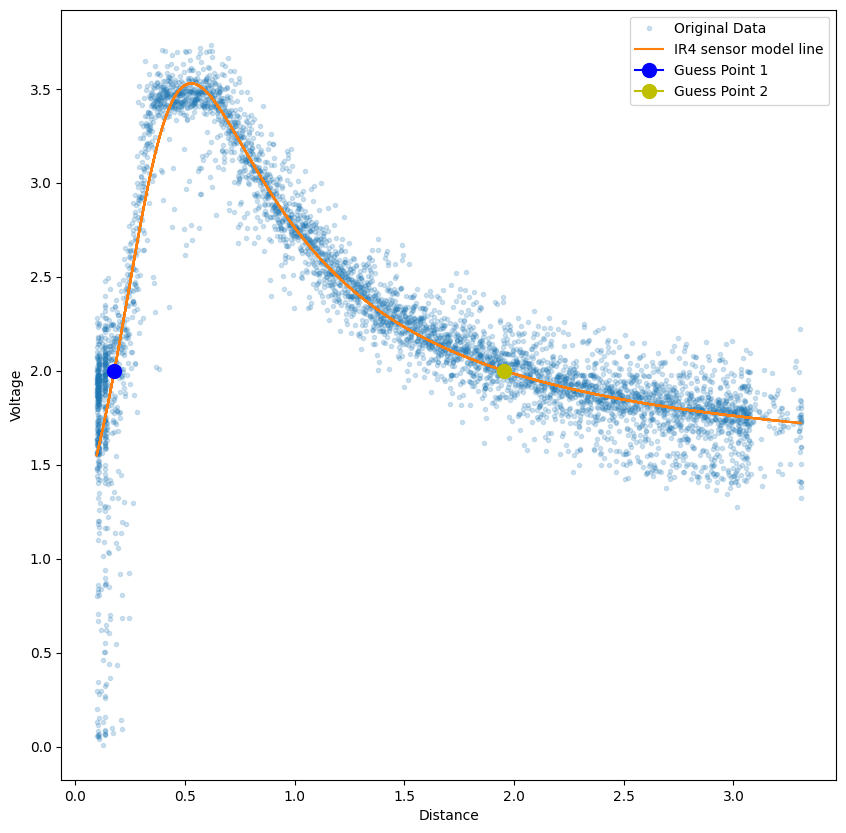

In [3]:
# Set the current 'z' value or target value

Vol_z = 2  # Use a specific value of 'z'
H_sensor_model = h_ir4  # Use the 'h_ir4' sensor model
print(H_sensor_model)

# Calculate two guesses ('gus1' and 'gus2') for the inversion of 'H_sensor_model' at 'cur_z'
gPoint1, gPoint2 = amb_H_invert(H_sensor_model, Vol_z, mid=1)
# print(gus1)

# Create a figure for plotting
plt.figure(figsize=(10, 10))
# plt.figure(figsize=(4, 3), dpi=150)

# Plot the original data points for IR4 with a label
plt.plot(distance, raw_ir4, '.', alpha=0.2, label='Original Data')

# Plot the curve generated by 'H_sensor_model' with a label
plt.plot(distance, H_sensor_model(distance), '-', label='IR4 sensor model line')

# Plot the guessed points ('gus1' and 'gus2') on the curve with labels and larger markers
try:
    plt.plot(gPoint1, H_sensor_model(gPoint1), '-bo', markersize=10, label='Guess Point 1')
    print(gPoint1)
    print(H_sensor_model(gPoint1))
except:
    pass

try:
    plt.plot(gPoint2, H_sensor_model(gPoint2), '-yo', markersize=10, label='Guess Point 2')
    print(gPoint2)
    print(H_sensor_model(gPoint2))
except:
    pass

# Add labels for the x-axis and y-axis
plt.xlabel("Distance")
plt.ylabel("Voltage")

# Add a legend
plt.legend()



In [4]:
def VarError_LookUpTable(x, error, xstep=0.3):
    """
    Calculate the mean and variance of error values based on a lookup table.

    Args:
        x (array): Array of lengths.
        error (array): Array of fitting curve error values.
        xstep (float): Step size for partitioning the data. Defaults to 0.1.

    Returns:
        tuple: Three arrays containing x-axis values, mean error values, and variance of error values.
    """
    x_now = xstep
    curbar = np.array([])

    x_mu = np.array([])
    std_x = np.array([])
    xaxis = np.array([])

    for i in range(0, len(x)):
        
        if (x[i] < x_now):
            
            curbar = np.append(curbar, error[i])
        else:
            error_std = np.std(curbar)
            error_mean = np.mean(curbar)
            x_mu = np.append(x_mu, error_mean)
            std_x = np.append(std_x, error_std)
            xaxis = np.append(xaxis, x[i])
            curbar = np.array([])
            x_now += xstep
    
    return xaxis, x_mu, std_x


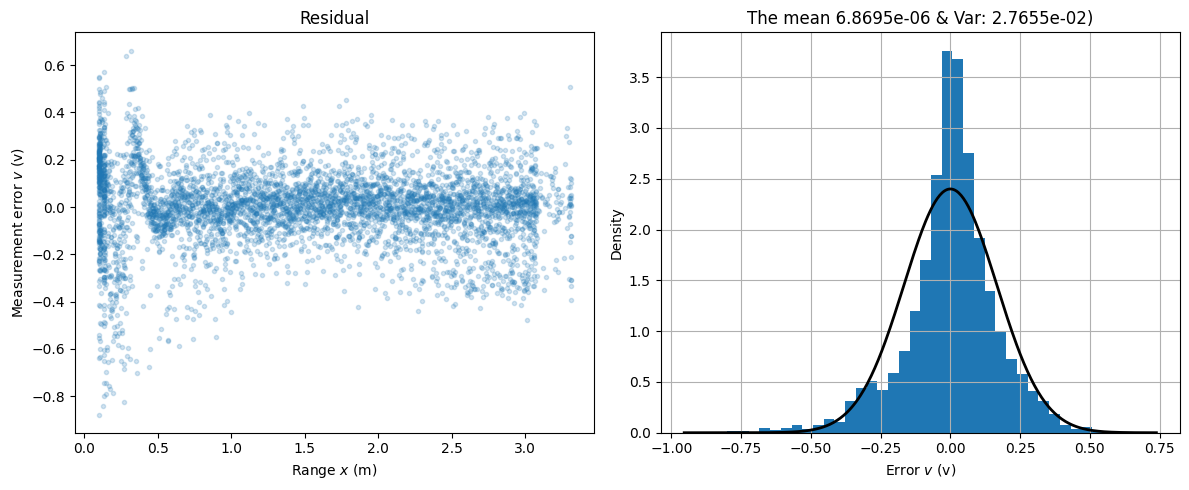

In [5]:
import Model.IR_model as mm
ir4_x, ir4_v,ir4_fit,ir4_params= mm.remove_outlier(mm.ir4_model,distance,raw_ir4,3)
ir4_mu, ir4_std,ERR_ir4 = mm.Residual_and_Histogram(ir4_x,ir4_v,ir4_fit)
# ERR_sn1 = sonar1 - sn1_model(distance, *filtered_params)
# print(sn1_params)

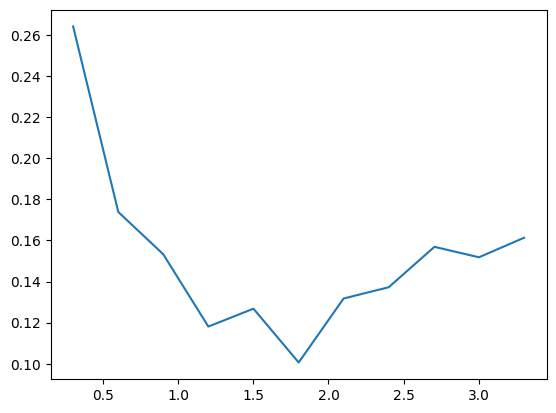

In [6]:
Xaxis_ir4, Mu_X_ir4, std_X_ir4 = VarError_LookUpTable(ir4_x,ERR_ir4,0.3)
''' Input: x, error, step  '''
# plt.figure()
# plt.plot(Xaxis_ir4,Mu_X_ir4)
plt.plot(Xaxis_ir4,std_X_ir4)

ir4 1 guess 0.178375244140625
ir4 2 guess 1.9542236328125


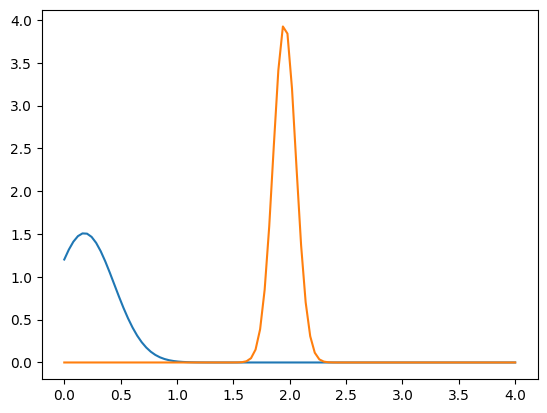

In [7]:
from scipy import stats
gPoint1, gPoint2 = amb_H_invert(H_sensor_model, Vol_z, mid=1)


def find_std_index(value, intervals):
    """
    根据给定的值和区间，找到该值所在的区间索引。

    参数：
    - value：要查找区间的值。
    - intervals：包含区间的NumPy数组。假定区间是已排序的。

    返回：
    - interval_index：值所在的区间索引。如果值小于第一个区间下限，返回0。
      如果值大于最后一个区间上限，返回len(intervals) - 1。
    """
    if value < intervals[0]:
        return 0
    if value >= intervals[-1]:
        return len(intervals) - 1
    for i in range(len(intervals) - 1):
        if value >= intervals[i] and value < intervals[i + 1]:
            return i
    return -1  # 如果值不在任何区间内，则返回-1


gPoint1_index = find_std_index(gPoint1, Xaxis_ir4)
gPoint2_index = find_std_index(gPoint2, Xaxis_ir4)

gPoint1_std = std_X_ir4[gPoint1_index]
gPoint2_std = std_X_ir4[gPoint2_index]


# Debug section
if not gPoint1 is None:
    L_1ir4 = stats.norm.pdf(x_values, loc=gPoint1, scale=(gPoint1_std))
    print(f"ir4 1 guess {gPoint1}")
    ir41Plot = plt.plot(x_values, L_1ir4)
else:
    ir41Plot = plt.plot()

if not gPoint2 is None:
    L_2ir4 = stats.norm.pdf(x_values, loc=gPoint2, scale=(gPoint2_std))
    print(f"ir4 2 guess {gPoint2}")
    ir42Plot = plt.plot(x_values, L_2ir4)
else:
    ir42Plot = plt.plot()

